# Recommendations with IBM

The data is from the IBM Watson Studio platform. 

## Table of Contents

I. [Exploratory Data Analysis](#eda)<br>
II. [Rank Based Recommendations](#rank)<br>
III. [User-User Based Collaborative Filtering](#user)<br>
IV. [Content Based Recommendations](#content)<br>
V. [Matrix Factorization](#svd)<br>
VI. [Conclusion](#conclusion)

### Import libraries and read in data

In [1]:
%matplotlib inline

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project_tests as t

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df['article_id'] = df.article_id.astype(int)
print(df.head(2))
df_content.head(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
   article_id                                              title  \
0        1430  using pixiedust for fast, flexible, and easier...   
1        1314       healthcare python streaming application demo   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1


### <a class="anchor" id="eda">Part I: Exploratory Data Analysis</a> 

### Number of article interactions by users

In [2]:
interaction_count = df.groupby('email').article_id.count()
median_val, max_views_by_user = interaction_count.median(), interaction_count.max() # median and max
interaction_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

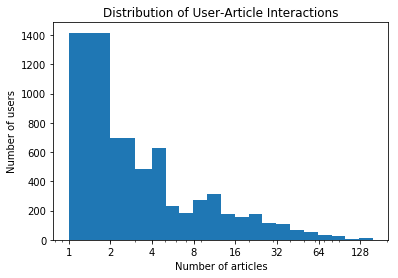

In [3]:
# Histogram layout
bins = [1, 2, 3] + list(10 ** np.arange(0.6, 2.25, 0.1))
ticks = 2 ** np.arange(0, 8)
plt.title('Distribution of User-Article Interactions')
plt.ylabel('Number of users')
plt.xlabel('Number of articles')

# Interaction distribution
interaction_count.hist(bins=bins, grid=False)
plt.xscale('log')
plt.xticks(ticks, ticks);

### Duplicate articles

In [4]:
df_content[df_content.duplicated(subset=['article_id'], keep=False)].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [5]:
# Drop duplicate articles
df_content.drop_duplicates(subset=['article_id'], inplace=True)
df_content[df_content.duplicated(subset=['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id


### User and article counts

In [6]:
unique_articles = df.article_id.nunique() # number of unique articles with at least one interaction
total_articles = df_content.shape[0] # number of unique articles on platform
unique_users = df.email.nunique() # number of unique users
user_article_interactions = df.shape[0] # number of user-article interactions

print('Articles with interaction(s):', unique_articles)
print('Articles on IBM platform:', total_articles)
print('Number of users:', unique_users)
print('Number of user-article interactions:', user_article_interactions)

Articles with interaction(s): 714
Articles on IBM platform: 1051
Number of users: 5148
Number of user-article interactions: 45993


In [7]:
# Most viewed article
most_viewed_article = df.article_id.value_counts()
most_viewed_article_id, max_views = most_viewed_article.index[0], most_viewed_article.max()
print('Most viewed article ID:', most_viewed_article_id)
print('Views:', max_views)

Most viewed article ID: 1429
Views: 937


#### After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [8]:
def email_mapper(interaction_df=df, email_col='email'):
    
    '''
    Map hashed email strings to numbered user IDs.
    
    Args:
        interaction_df (Pandas dataframe) - interaction data
        email_col (str) - name of email column
    
    Returns:
        User IDs encoded from emails (list[int]).
    '''
    
    user_dict = dict()
    email_encoded = []
    i = 1
    
    for user in interaction_df[email_col]:
        if user not in user_dict:
            user_dict[user] = i
            i += 1
        email_encoded.append(user_dict[user])
        
    return email_encoded


# Map emails to user IDs
df['user_id'] = email_mapper()
del df['email']
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


### Tests

In [9]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': str(float(most_viewed_article_id)),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="rank">Part II: Rank-Based Recommendations</a>

#### Since there is no indication of whether or not users liked an article, the popularity of an article can really only be based on how often an article was interacted with.

In [10]:
unique_articles = df.article_id.nunique() # number of unique articles with at least one interaction


def get_top_articles(n_top=unique_articles, interaction_df=df,
                     arti_col='title', user_col='user_id'):
    
    '''
    Get the top articles in terms of how many times it was interacted with.
    
    Args:
        (1) n_top (int) - number of top articles to return, or return all articles if not specified
        (2) interaction_df (Pandas dataframe) - interaction data
        (3) arti_col (str) - name of article column (either name or ID)
        (4) user_col (str) - name of user ID column
    
    Returns:
        Top `n_top` article IDs (list[int]) or article names (list[str]).
        Default: article names.
    '''
    
    top_articles = interaction_df.groupby(arti_col)[user_col].count().sort_values(ascending=False).index.tolist()
    return top_articles[:n_top]


print(get_top_articles(10, arti_col='article_id'))
print(get_top_articles(10))

[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


### Tests

In [11]:
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="user">Part III: User-User Based Collaborative Filtering</a>

### User-article matrix

In [12]:
def create_user_item_matrix(interaction_df=df, user_col='user_id',
                            aid_col='article_id', aname_col='title'):
    
    '''
    Create a user-article matrix with users as the rows, articles as the columns, and binary values.
    The binary values in the matrix indicate whether a user has interacted with each article, no 
    matter how many times the user has interacted with that article.
    
    Args:
        (1) interaction_df (Pandas dataframe) - interaction data
        (2) user_col (str) - name of user ID column
        (3) aid_col (str) - name of article ID column
        (4) aname_col (str) - name of article name column
        
    Returns:
        User-item matrix with binary values (Pandas dataframe).
    '''
    
    return interaction_df.groupby([user_col, aid_col])[aname_col].nunique().unstack(fill_value=0)


# Create user-article matrix
user_item = create_user_item_matrix(df)

# Tests
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."

user_item.head(2)

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### User similarity

In [13]:
def find_similar_users(user_id, ua_matrix=user_item):
    
    '''
    Find the most similar users to a specified user based on the articles they have interacted with.
    
    Args:
    (1) user_id (int) - user ID to find similar users for
    (2) ua_matrix (Pandas dataframe) - user-article binary matrix
    
    Returns:
        All user IDs in order from most similar to least similar (list[int])
    '''
    
    user_id = int(float(user_id)) # ensure user id is an integer
    similarity = ua_matrix.loc[user_id].dot(ua_matrix.T) # user similarities
    most_similar_users = similarity.sort_values(ascending=False).index.tolist() # user IDs from most to least similar
    most_similar_users.remove(user_id) # remove specified user
    return most_similar_users


print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


### Recommender

In [14]:
def get_article_names(article_ids, article_df=df,
                      id_col='article_id', name_col='title'):
    
    '''
    Get article names from article IDs.
    
    Args:
        (1) article_ids (list[int]) - article IDs to get names for
        (2) article_df (Pandas dataframe) - data with article names and IDs
        (3) id_col (str) - name of article ID column
        (4) name_col (str) - name of article name column
    
    Returns:
        Names of specified article IDs (list[str]).
    '''
    
    article_ids = [int(float(article_id)) for article_id in article_ids]
    articles = article_df.set_index(id_col)[name_col].drop_duplicates()
    return articles[article_ids].tolist()


def get_user_articles(user_id, ua_matrix=user_item,
                      article_df=df, id_col='article_id', name_col='title'):
    
    '''
    Get articles a specified user has interacted with.
    
    Args:
        (1) user_id (int) - user ID to get seen articles for
        (2) ua_matrix (Pandas dataframe) - user-article binary matrix
        (3) article_df (Pandas dataframe) - data with article names and IDs *
        (4) id_col (str) - name of article ID column *
        (5) name_col (str) - name of article name column *
        * Pass-through args for `get_article_names` function
    
    Returns:
        (1) IDs of articles the user has interacted with (list[int]).
        (2) Names of articles the user has interacted with (list[str]).
    '''
    
    user_id = int(float(user_id))
    articles = ua_matrix.loc[user_id]
    article_ids = articles[articles > 0].index.tolist()
    article_names = get_article_names(article_ids, article_df, id_col, name_col)
    return article_ids, article_names


def user_user_recs(user_id, n_recs=10,
                   ua_matrix=user_item, interaction_df=df,
                   id_col='article_id', name_col='title'):
    
    '''
    Find the most similar users (neighbors) to the specified user and recommend to that user
    articles that neighbors have interacted with. Neighbors with the same closeness are 
    chosen arbitrarily as the next user. For the user where the number of recommended articles
    starts below `n_recs` and ends exceeding `n_recs`, the last items are chosen arbitrarily.
    
    Args:
        (1) user_id (int) - user ID to make recommendations for
        (2) n_recs (int) - number of recommendations to make
        (3) ua_matrix (Pandas dataframe) - user-article binary matrix *
        (4) interaction_df (Pandas dataframe) - interaction data *
        (5) id_col (str) - name of article ID column *
        (6) name_col (str) - name of article name column *
        * Pass-through args for `get_user_articles` function
    
    Returns:
        IDs of recommended articles (list[int]).
    '''
    
    user_id = int(float(user_id)) # ensure user id is an integer
    seen_ids = get_user_articles(user_id, ua_matrix, interaction_df, id_col, name_col)[0] # articles already seen by user
    neighbors = find_similar_users(user_id, ua_matrix) # similar users (neighbors)
    recs = []
    
    for nb in neighbors:
        nb_articles = np.setdiff1d(get_user_articles(nb, ua_matrix, interaction_df, id_col, name_col)[0],
                                   seen_ids) # neighbor articles
        for article in nb_articles:
            if article not in recs: # if the article is not already in recommendations
                recs.append(article)
        if len(recs) >= n_recs: # if there are enough recommendations
            break
    
    return recs[:n_recs]


# tests
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])

# 10 recommendations for user 1
user1_recs = user_user_recs(1, 10)
print(user1_recs)
get_article_names(user1_recs)

[2, 12, 14, 16, 26, 28, 29, 33, 50, 74]


['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [15]:
arr1 = np.array([1, 5, 7, 9, 3, 2])
arr2 = np.array([4, 5, 2, 7])
np.setdiff1d(arr1, arr2)

array([1, 3, 9])

In [16]:
def get_top_sorted_users(user_id, interaction_df=df, ua_matrix=user_item):
    
    '''
    Get all users sorted from most similar to least similar to a specified user.
    Users that have the same similarity is sorted from those with the most
    article interactions to those with the least.
    
    Args:
        (1) user_id (int) - user ID to find similar uses for
        (2) interaction_df (Pandas dataframe) - interaction data
        (3) ua_matrix (Pandas dataframe) - user-article binary matrix
        
    Returns:
        All users sorted in descending order by similarity then number of 
        interactions (Pandas dataframe).
    '''
    
    user_id = int(float(user_id)) # ensure user id is an integer
    neighbors = ua_matrix.loc[user_id].dot(ua_matrix.T)
    
    neighbors_df = neighbors[neighbors.index != user_id].reset_index() # neighbor similarity
    neighbors_df.columns = ['neighbor_id', 'similarity']
    
    n_interactions = ua_matrix.sum(axis=1).reset_index() # neighbor interactions
    n_interactions.columns = ['neighbor_id', 'n_interactions']
    
    neighbors_df = pd.merge(neighbors_df, n_interactions, on='neighbor_id', how='left')
    return neighbors_df.sort_values(['similarity', 'n_interactions'], ascending=False)


def user_user_recs_part2(user_id, n_recs=10, ua_matrix=user_item, 
                         n_top_articles=unique_articles, interaction_df=df, 
                         user_col='user_id', aid_col='article_id', aname_col='title'):
    
    '''
    Find the most similar users (neighbors) to the specified user and recommend to that user
    articles that neighbors have interacted with. Neighbors with the same closeness are 
    chosen in the order of most to least article interactions. For the user where the number 
    of recommended articles starts below `n_recs` and ends exceeding `n_recs`, articles are
    chosen in the order of most to least user interactions.
    
    Args:
        (1) user_id (int) - user ID to make recommendations for
        (2) n_recs (int) - number of recommendations to make
        (3) ua_matrix (Pandas dataframe) - user-article binary matrix
        (4) n_top_articles (int) - number of top articles to return, or return all articles if not specified *
        (5) interaction_df (Pandas dataframe) - interaction data *
        (6) user_col (str) - name of user ID column *
        (7) aid_col (str) - name of article ID column *
        (8) aname_col (str) - name of article name column *
        * Pass-through args for `get_top_articles`, `get_user_articles`, and `get_top_sorted_users` functions
    
    Returns:
        (1) IDs of recommended articles (list[int]).
        (2) Names of recommended articles (list[str]).
    '''
    
    user_id = int(float(user_id)) # ensure user id is an integer
    top_articles = get_top_articles(n_top_articles, interaction_df, aid_col, user_col) # all articles sorted
    
    if user_id in ua_matrix.index: # for existing users
        seen_ids = get_user_articles(user_id, ua_matrix, interaction_df, aid_col, aname_col)[0] # articles already seen by user
        neighbors = get_top_sorted_users(user_id, interaction_df, ua_matrix).neighbor_id.tolist() # sorted neighbors
        rec_ids = [] # recommended article ids

        for neighbor in neighbors: # iterate through neighbors
            n_recs -= len(rec_ids) # number of recommendations needed
            if n_recs <= 0:
                break
                
            neighbor_articles = get_user_articles(neighbor, ua_matrix, interaction_df, aid_col, aname_col)[0] # neighbor article ids
            neighbor_articles = np.setdiff1d(neighbor_articles, seen_ids) # remove seen articles from neighbor articles
            top_neighbor_articles = [article for article in top_articles if article in neighbor_articles] # sort neighbor articles
            rec_ids.extend(top_neighbor_articles[:n_recs]) # add neighbor article ids up to the number of recommendations needed
    
    else: # for new users
        rec_ids = top_articles[:n_recs] # recommended article ids
        
    return rec_ids, get_article_names(rec_ids, interaction_df, aid_col, aname_col) # recommended article ids and names


# 10 recommendations for user 20
rec_ids, rec_names = user_user_recs_part2(20)
rec_ids, rec_names

([1429, 1330, 1314, 1293, 1162, 1271, 43, 1351, 1368, 1305],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'analyze energy consumption in buildings',
  'customer demographics and sales',
  'deep learning with tensorflow course by big data university',
  'model bike sharing data with spss',
  'putting a human face on machine learning',
  'gosales transactions for naive bayes model'])

### Tests

In [17]:
user1_most_sim = get_top_sorted_users(1).iloc[0, 0] # user 1's most similar user
user131_10th_sim = get_top_sorted_users(131).iloc[10, 0] # user 131's 10th most similar user
user1_most_sim, user131_10th_sim

(3933, 242)

In [18]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


In [19]:
# Try a new user
new_user = '0.0'
new_user_recs = user_user_recs_part2(new_user)
assert set(new_user_recs[0]) == set([1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."
new_user_recs

([1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304],
 ['use deep learning for image classification',
  'insights from new york car accident reports',
  'visualize car data with brunel',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'predicting churn with the spss random tree algorithm',
  'healthcare python streaming application demo',
  'finding optimal locations of new store using decision optimization',
  'apache spark lab, part 1: basic concepts',
  'analyze energy consumption in buildings',
  'gosales transactions for logistic regression model'])

#### For existing users, recommendations are made by finding the most similar users and then recommending articles these similar users have interacted with that the user of interest has not. This cannot be done for new users, so the rank-based recommender is used instead (articles with the most interactions are recommended).

### <a class="anchor" id="content">Part IV: Content Based Recommendations</a>

### Article Content

In [20]:
def add_interactions_to_content(interactions_df=df, content_df=df_content, arti_col='article_id', user_col='user_id'):
    
    '''
    Add the number of user interactions to the content data.
    
    Args:
        (1) interactions_df (Pandas dataframe) - interaction data
        (2) content_df (Pandas dataframe) - article content data
        (3) arti_col (str) - name of article ID column
        (4) user_col (str) - name of user ID column
        
    Returns:
        Content data with interaction count added to it (Pandas dataframe)
    '''
    
    n_interactions = interactions_df.groupby(arti_col)[user_col].count().reset_index() # count user interactions per article
    n_interactions.columns = [arti_col, 'n_interactions'] # rename interaction column
    
    content = pd.merge(content_df.dropna(), n_interactions, on=arti_col, how='left') # drop articles with null values
    content['n_interactions'] = content.n_interactions.fillna(0).astype(int) # fill articles with no user interactions with 0 and recast as integers
    return content


# Add user interaction count to content data
content = add_interactions_to_content()
content.head(2)

,doc_body,doc_description,doc_full_name,doc_status,article_id,n_interactions
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,14
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,0


In [21]:
def weigh_text(name_col='doc_full_name', name_weight=1, 
               desc_col='doc_description', desc_weight=1, 
               body_col='doc_body', body_weight=1):
    
    '''
    Add weights to the text columns. For columns with a weight of 1, the text will
    be considered 1 time for computations. For columns with weights greater than 1, 
    the text will be repeated that many times. This is done in order to emphasize
    the importance of certain text over others.
    
    Example: for a name weight of 2, the article names will be considered 2 times.
    
    Args:
        (1) name_col (str) - name of article name column
        (2) name_weight (int) - weight for name column
        (3) desc_col (str) - name of article description column
        (4) desc_weight (int) - weight for description column
        (5) body_col (str) - name of article body column
        (6) body_weight (int) - weight for body column
        
    Returns:
        Text columns in multiples of their corresponding weights (list)
    '''
    
    return [name_col] * name_weight + [desc_col] * desc_weight + [body_col] * body_weight


def combine_text(content_df, text_cols=['doc_full_name', 'doc_description', 'doc_body']):
    
    '''
    Combine all text into 1 column.
    
    Args:
        (1) content_df (Pandas dataframe) - article content data
        (2) text_cols (list[str]) - names of text columns to combine
        
    Returns:
        Column with all text combined (Pandas series)
    '''
    
    doc = content_df[text_cols[0]].copy() # first text column
    for col in text_cols[1:]: # for every column after the first
        doc += ' ' + content_df[col] # concatenate the next column
    return doc
    

def get_word_count(text_series):
    
    '''
    Get the word count of a text column.
    
    Args:
        text_series (Pandas series) - column of text
        
    Returns:
        Word count colunmn (Pandas series)
    '''
    
    return text_series.apply(lambda d: len(d.split()))
    

# Weigh sections of article text
text_cols = weigh_text(name_weight=5, desc_weight=2, body_weight=1)
print(text_cols)
    
# Add full text and word count columns
content['doc'] = combine_text(content, text_cols)
content['word_count'] = get_word_count(content.doc)
content.head(2)

['doc_full_name', 'doc_full_name', 'doc_full_name', 'doc_full_name', 'doc_full_name', 'doc_description', 'doc_description', 'doc_body']


,doc_body,doc_description,doc_full_name,doc_status,article_id,n_interactions,doc,word_count
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,14,Detect Malfunctioning IoT Sensors with Streami...,738
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,0,Communicating data science: A guide to present...,3535


### Topic modeling

In [22]:
stop = stopwords.words('english') # stopwords
stemmer = SnowballStemmer('english') # word stemmer
    
    
def tokenize(text):
    
    '''
    Get a processed bag of words from a string of text.
    
    Process:
        (1) Lowercase characters
        (2) remove punctuation
        (3) tokenize text
        (4) remove stopwords
        (5) stem words.
        
    Args:
        text (str) - text to tokenize
        
    Returns:
        Stemmed tokens (list[str])
    '''
    
    tokens = word_tokenize(re.sub(r'[^A-Za-z0-9]', ' ', text.lower())) # steps 1 - 3
    stopwords_removed = np.setdiff1d(tokens, stop).tolist() # step 4
    return [stemmer.stem(word) for word in stopwords_removed] # step 5


def vectorize(corpus, tfidf=True):
    
    '''
    Vectorize a corpus of text.
    
    Args:
        (1) corpus (array-like[str]) - list of documents to vectorize
        (2) tfidf (bool) - whether or not to use tf-idf vectorizer, if not then use count vectorizer
        
    Returns:
        Document-token matrix (Pandas DataFrame)
    '''
    
    if tfidf:
        vec = TfidfVectorizer(tokenizer=tokenize)
    else:
        vec = CountVectorizer(tokenizer=tokenize)
        
    matrix = vec.fit_transform(corpus)
    matrix_df = pd.DataFrame(matrix.todense(), columns=vec.get_feature_names())
    return matrix_df


# Vectorize corpus with tfidf
doc_tfidf = vectorize(content.doc)
print(doc_tfidf.shape)
doc_tfidf.head(2)

(1034, 30829)


,0,00,000,0000,00000,000000,0000000,00000000,000000000,000000000000,...,zuckerberg,zuk,zulu,zume,zumel,zunix,zurich,zushi,zwick,zz
0,0.0,0.052992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
def get_article_topics(doc_vectors, n_comps=10):
    
    '''
    Use non-negative matrix factorization to find latent article topics.
    
    Args:
        (1) doc_vectors (matrix-like[float]) - matrix of vectorized documents
        (2) n_comps (int) - number of topics to find
    
    Returns:
        (1) Article-topic matrix containing coefficients for each article-topic pair (Pandas dataframe)
        (2) Token vector for each topic (2D Numpy array)
    '''
    
    nmf = NMF(n_comps, random_state=0)
    topics = nmf.fit_transform(doc_vectors)
    topics_df = pd.DataFrame(topics, columns=[f'topic{n + 1}' for n in range(n_comps)])
    return topics_df, nmf.components_


def show_comp_top_words(nmf_comps, vocab, n_words=20):
    
    '''
    Print the top words for each latent feature.
    
    Args:
        (1) nmf_comps (2D array-like) - components from NMF (article topics)
        (2) vocab (list[str]) - tokens from vectorizer
        (3) n_words (int or float) - number of top words to print if integer, 
                                     or proportion of vocabulary to print if float
    
    Returns: None
    '''
    
    if isinstance(n_words, float): # if number of words is a float
        n_words = int(len(vocab) * n_words) # calculate the actual number of words
        
    print(f'Top {n_words} words for each topic:\n')
    n_words += 1 # for reverse indexing
    
    for topic, comp in enumerate(nmf_comps): # for each topic
        print(topic, [vocab[i] for i in comp.argsort()[-1:-n_words:-1]], '\n') # print the topic number and top words for each topic
        
        
# Topics from full article text
arti_topic, topic_word = get_article_topics(doc_tfidf, 50)
print(f'Article-topic matrix: {arti_topic.shape}\nTopic-word matrix: {topic_word.shape}\n') # shape of 2 NMF matrices
show_comp_top_words(topic_word, doc_tfidf.columns) # top 20 words for each topic
arti_topic.describe()

Article-topic matrix: (1034, 50)
Topic-word matrix: (50, 30829)

Top 20 words for each topic:

0 ['index', 'queri', 'field', 'defin', 'type', 'document', 'oper', 'key', 'insert', 'search', 'store', 'row', 'return', 'array', 'use', 'creat', 'allow', 'function', 'tabl', 'perform'] 

1 ['authent', 'script', 'notebook', 'command', 'index', 'dcw', 'agin', 'movetocloud', 'informatica', 'netezza', 'embedd', 'arcgi', 'esri', 'basket', 'puredata', 'workbench', 'tableau', 'aspera', 'datawork', 'report'] 

2 ['predict', 'train', 'model', 'classifi', 'algorithm', 'score', 'regress', 'tree', 'perform', 'ensembl', 'random', 'classif', 'combin', 'cluster', 'featur', 'dataset', 'split', 'forest', 'valid', 'evalu'] 

3 ['playlist', 'load', 'suggest', 'closethi', 'reportne', 'towant', 'helpload', 'lateradd', 'rent', 'searchload', 'unsubscrib', 'undo', 'yeah', '0don', '1load', 'autoplay', 'lessload', 'unavail', 'durat', 'inappropri'] 

4 ['badg', 'post', 'address', 'subcrib', 'facebookfollow', 'bdu', 'pa

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,...,topic41,topic42,topic43,topic44,topic45,topic46,topic47,topic48,topic49,topic50
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,...,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,0.005456,0.012043,0.006167,0.011100,0.007265,0.013422,0.010562,0.008302,0.005989,0.004169,...,0.014887,0.005534,0.011458,0.005709,0.008163,0.011086,0.011640,0.005361,0.007137,0.011364
std,0.012076,0.062068,0.017819,0.048072,0.029214,0.039038,0.048149,0.033385,0.021437,0.021349,...,0.055395,0.037557,0.042637,0.036274,0.061264,0.048776,0.042714,0.038693,0.044077,0.044807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.004774,0.001719,0.001434,0.000864,0.000980,0.002528,0.006269,0.002003,0.002123,0.000499,...,0.002646,0.002147,0.000000,0.003206,0.000000,0.003738,0.012198,0.002096,0.005159,0.007281
max,0.088327,0.442584,0.144133,0.343072,0.204580,0.305946,0.445601,0.341345,0.251056,0.186446,...,0.566881,0.839400,0.455786,0.625340,0.789291,0.732277,0.877911,0.851298,0.859462,0.865875


### Article similarity

In [24]:
def coefs_to_binary(coef_mat, threshold):
    
    '''
    Convert a coefficient matrix's values to binary values: 
    1 if the coefficient passes a specified threshold, or 0 if not
    
    Args:
        (1) coef_mat (Pandas dataframe) - coefficient matrix
        (2) threshold (float) - coefficient minimum to convert value to 1
        
    Returns:
        Coefficient matrix converted to binary values (Pandas dataframe)
    '''
    
    mat_binary = coef_mat.copy()
    for col in mat_binary.columns:
        mat_binary[col] = mat_binary[col].apply(lambda coef: 1 if coef >= threshold else 0)
    return mat_binary


def create_article_similary_matrix(bin_mat):
    
    '''
    Use the computed article topics to find the similarity between all article pairs.
    Since not all articles have the same number of topics, similarity values will be
    converted to relative terms based on the number of topics that article has.
    
    Args:
        bin_mat (Pandas dataframe) - coefficient matrix with binary values
    
    Returns:
        Similarity matrix with relative values (Pandas dataframe).
    '''
    
    similarity = bin_mat.dot(bin_mat.T) # similarity matrix
    similarity['n_topics'] = bin_mat.sum(axis=1) + 0.01 # topic count for each article (+ 0.01 to prevent division by 0)

    for i in range(similarity.shape[0]):
        similarity.iloc[i, i] = 0 # remove similarity with self
        similarity.iloc[:, i] /= similarity.n_topics # convert similarity to relative terms
        
    return similarity


# Article similarity matrix
arti_topic_bin = coefs_to_binary(arti_topic, 0.05) # convert matrix to binary values
article_similarity = create_article_similary_matrix(arti_topic_bin)
article_similarity.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1025,1026,1027,1028,1029,1030,1031,1032,1033,n_topics
0,0.0,0.0,0.0,0.0,0.497512,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.01
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.497512,0.0,0.0,0.0,0.0,2.01


### Recommender

In [25]:
def get_similar_articles(article_id, similarity_mat=article_similarity,
                         n_articles=article_similarity.shape[0], threshold=0.5):
    
    '''
    Find all similar articles for a given article. Articles must have a minimum relative
    similarity of the specified threshold in order to be considered similar. Similar 
    articles will be sorted in descending order by the similarity values and then the 
    number of topics the articles have (most similar to least similar).
    
    Args: 
        (1) article_id (int) - article ID to find similar articles for
        (2) similarity_mat (Pandas dataframe) - computed similarity matrix for articles
        (3) n_articles (int) - number of similar articles to return
        (4) threshold (float) - minimum relative similarity to be considered similar
        
    Returns:
        IDs of imilar articles (list[int])
    '''
    
    article_id = int(float(article_id)) # ensure article ID is an integer
    if article_id not in similarity_mat.columns: # for new articles
        return [] # there are no similar articles
    
    similarities = similarity_mat[article_id] # similarities for article of interest
    similarities = similarities[similarities >= threshold] # filter for similar articles
    return similarities.sort_values(ascending=False).index.tolist()[:n_articles] # sort in descending order
    
    
def make_content_recs(user_id, n_recs=10,
                      ua_matrix=user_item, content_df=content, interaction_df=df,
                      user_col='user_id', aid_col='article_id', 
                      aname_col_content='doc_full_name', aname_col_interaction='title'):
    
    '''
    Recommend to users articles similar to articles they've already seen (interacted with).
    A similar article will be recommended for each seen article before the next similar 
    article is recommended. This continues until the specified number of recommendations is
    met. Recommendations are made from most similar to least similar articles.
    
    Example:
        User A has seen articles 102 and 304.
        6 recommendations for user A made in order:
            (1) article 102's most similar article
            (2) article 304's most similar article
            (3) article 102's 2nd most similar article
            (4) article 304's 2nd most similar article
            (5) article 102's 3rd most similar article
            (6) article 304's 3rd most similar article
    
    Args:
        (1) user_id (int) - user ID to make recommendations for
        (2) n_recs (int) - number of recommendations to make
        (3) ua_matrix (Pandas dataframe) - user-article binary matrix
        (4) content_df (Pandas dataframe) - article content data
        (5) interaction_df (Pandas dataframe) - interaction data *
        (6) user_col (str) - name of user ID column *
        (7) aid_col (str) - name of article ID column *
        (8) aname_col_content (str) - name of article name column in article content data *
        (9) aname_col_interaction (str) - name of article name column in interaction data*
        * Pass-through args for `get_user_articles` and `get_article_names` functions
        
    Returns:
        (1) IDs of recommended articles (list[int])
        (2) Names of recommended articles (list[str])
    '''
    
    # Recommend top articles for new users
    user_id = int(float(user_id)) 
    if user_id not in ua_matrix.index:
        rec_ids = get_top_articles(n_recs, interaction_df, aid_col, user_col) # all articles sorted
        return rec_ids, get_article_names(rec_ids, interaction_df, aid_col, aname_col_interaction)
    
    # Articles the user has interacted with
    seen_ids = get_user_articles(user_id, ua_matrix, content_df, aid_col, aname_col_content)[0]
    seen_ids = [int(float(article_id)) for article_id in seen_ids]
    
    # Similar articles for all seen articles
    similar_articles = []
    for article_id in seen_ids:
        sim = get_similar_articles(article_id)
        if len(sim):
            similar_articles.append(sim)
    
    # Order similar articles so that a similar article is recommended for each of the seen articles
    max_sim = max([len(sim) for sim in similar_articles])
    for i, a in enumerate(similar_articles):
        similar_articles[i].extend([-1] * (max_sim - len(a)))
    recs = np.array(similar_articles).T.flatten()
    
    # Unique unseen articles
    recs_unique = []
    for rec in recs:
        if rec >= 0 and rec in content_df.article_id.values:
            if rec not in seen_ids and rec not in recs_unique:
                recs_unique.append(rec)
            
    # Top recommendations
    rec_ids = recs_unique[:n_recs]
    return rec_ids, get_article_names(rec_ids, content_df, aid_col, aname_col_content)
    

print(make_content_recs('0.0')) # 10 recommendations for a new user
make_content_recs(1000) # 10 recommendations for user 1000

([1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304], ['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model'])


([638, 1009, 635, 918, 199, 619, 98, 18, 607, 130],
 ['Metrics Maven: Calculating a Weighted Average in PostgreSQL',
  'Review the HTTP API',
  'UX Improvements to Cloudant Data-Replication',
  'Tell Me Something I Don’t Know – IBM Watson Data Lab – Medium',
  'DataLayer Conference: Storage Wars - The Art Genome Project',
  'Connecting to RethinkDB with Elixir',
  'How to map USA rivers using ggplot2',
  'The Greatest Public Datasets for AI – Startup Grind',
  'Recommendation System Algorithms – Stats and Bots',
  "Feature importance and why it's important"])

##### The recommender above makes recommendations to users by finding articles most similar to articles the user has interacted with before. Similarity is determined by the topics found within each article. The topics are computed using non-negative matrix factorization (NMF).

##### To set up the data for the recommender, the process is as follows:
1. Add a weight to name, description, and body of the article and combine all the text into a single document for each article.
    - The weight is a multiple of the number of times that text appears in the combined document. For example, a weight of 5 for the article name means that the article name will be repeated 4 more times for a total of 5 times in the combined document. This increases the frequency of all words in the article name, which emphasizes their importance.
2. Transform the combined text into a vector of tf-idf coefficients for each article using word tokens from the entire collection of articles.
3. Use non-negative matrix factorization (NMF) to find latent features (or topics in this case) for the collection of articles.
    - Instead of choosing the topic with the highest computed coefficient for each article, a minimum coefficient determines if that article falls under each topic. Coefficients greater than or equal to this minimum is converted into 1 and the rest 0. In other words, not all articles will have the same number of topics. An article may have more than 1 topic, or even none.
4. Now that the article-topic matrix contains only binary values, compute the dot product between this matrix and its transpose matrix to yield article similarity.
    - Since not all articles have the same number of topics, the resulting similarity matrix isn't exactly reliable.
        - For example: article `A` and article `B` both only have topic 2 so they have a similarity value of 1. Article `C` has topics 3 and 4, while article `D` has topics 4, 5, 6, and 7. Articles C and D only have 1 topic in common, so their similarity value is also 1. 
        - In the above example, articles `A` and `B` are likely more similar to each other than articles `C` and `D` are to each other, but they both have the same similarity value of 1.
    - For this reason, the similarity values are converted into relative terms, by dividing the number of topics one of the articles has (the one we are finding similarities for).
        - 0.01 is added to the number of topics to avoid dividing by 0, but also to put more importance on articles with more topics. In other words, 4/4.01 > 3/3.01 > 2/2.01 > 1/1.01. This is an added benefit because articles with more topics in common are likely to be more similar.

##### Now for the recommender itself:
1. Get a list of articles the user has already seen.
2. For each seen article, find all similar articles.
    - Only articles with a relative similarity value above a specified threshold are kept.
    - Now there should be a 2D array: a list of similar articles for each seen article
3. Transpose and flatten the 2D array and make recommendations in that order. This way, a single recommendation can be made for each seen article first before moving to the 2nd recommendation for each article.
4. Add unique and unseen articles to the recommendation list.

### <a class="anchor" id="svd">Part V: Matrix Factorization</a>

### SVD on full dataset

In [26]:
# User-article matrix
ua_matrix = pd.read_pickle('user_item_matrix.p')
ua_matrix.columns = [int(float(article_id)) for article_id in ua_matrix.columns]
ua_matrix.head(2)

,0,100,1000,1004,1006,1008,101,1014,1015,1016,...,977,98,981,984,985,986,990,993,996,997
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# SVD
u, s, vt = np.linalg.svd(ua_matrix)
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

#### SVD can be used here because there are no missing values. The values in the user-article matrix indicate whether a user has seen each article. If the user hasn't seen a certain article, that value is just 0.

### Number of latent features

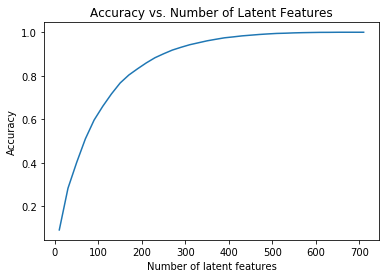

In [28]:
def test_num_latent_feats(u_mat=u, s_mat=s, vt_mat=vt, ua_mat=ua_matrix, k_start=10, k_step=20):
    
    '''
    Test a range of number of latent features by using them to estimate the original
    user-article matrix, and plot the accuracy for each estimation iteration. 
    This plot is used to find the optimal number of latent features.
    
    Args:
        (1) u_mat (2D array) - u matrix from SVD
        (2) s_mat (1D array) - s matrix from SVD
        (3) vt_mat (2D array) - v-transpose matrix from SVD
        (4) ua_mat (Pandas dataframe) - user-article binary matrix
        (5) k_start (int) - first number of latent features in the range to test
        (6) k_step (int) - iteration step for range of number of latent features
        
    Returns: None
    '''
    
    n_feats, errs = np.arange(k_start, s_mat.shape[0], k_step), []

    for k in n_feats:
        u_sub, s_sub, vt_sub = u_mat[:, :k], np.diag(s_mat[:k]), vt_mat[:k, :] # SVD matrices with `k` latent features
        ua_est = np.around(np.dot(np.dot(u_sub, s_sub), vt_sub)) # estimate original user-article matrix using `k` latent features
        diffs = np.subtract(ua_mat, ua_est) # error matrix between actual and predicted values
        errs.append(diffs.abs().sum().sum())

    # Plot errors
    plt.plot(n_feats, 1 - np.array(errs) / ua_mat.sum().sum())
    plt.title('Accuracy vs. Number of Latent Features')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of latent features')
    plt.show()


# Check estimate accuracy against number of latent features
test_num_latent_feats()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [29]:
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


### Train/test split

In [30]:
def create_train_and_test_user_item(interaction_df=df, train_size=40000,
                                    user_col='user_id', aid_col='article_id', aname_col='title'):
    
    '''
    Split the data into training and test sets by interaction time, and create
    a user-article matrix for each set.
    
    Args:
        (1) interaction_df (Pandas dataframe) - interaction data
        (2) train_size (int or float) - number of samples to split into the training set if integer,
                                        or proportion of the dataset if float
        (3) user_col (str) - name of user ID column *
        (4) aid_col (str) - name of article ID column *
        (5) aname_col (str) - name of article name column *
        * Pass-through args for `create_user_item_matrix` function
    
    Returns:
        (1) user-article matrix for the training set (Pandas dataframe)
        (2) user-article matrix for the test set (Pandas dataframe)
    '''
    
    if isinstance(train_size, float): # if train set size is a float
        train_size = int(interaction_df.shape[0] * train_size) # convert to actual size
    test_size = interaction_df.shape[0] - train_size # test set size
    df_train, df_test = interaction_df.head(train_size), interaction_df.tail(test_size) # train/test split

    ua_train = create_user_item_matrix(df_train, user_col, aid_col, aname_col)
    ua_test = create_user_item_matrix(df_test, user_col, aid_col, aname_col)
    return ua_train, ua_test


# Split data and create a user-article matrix for both
ua_train, ua_test = create_train_and_test_user_item()
ua_train.shape, ua_test.shape

((4487, 714), (682, 574))

### Tests

In [31]:
train_users, train_artis = ua_train.index.tolist(), ua_train.columns.tolist() # train set users and articles
test_users, test_artis = ua_test.index.tolist(), ua_test.columns.tolist() # test set users and articles

print('Test users that predictions can be made for:', np.intersect1d(test_users, train_users).shape[0])
print('Test users that predictions cannot be made for:', ua_test.shape[0] - np.intersect1d(test_users, train_users).shape[0])
print('Test articles that predictions can be made for:', np.intersect1d(test_artis, train_artis).shape[0])
print('Test articles that predictions cannot be made for:', ua_test.shape[1] - np.intersect1d(test_artis, train_artis).shape[0])

Test users that predictions can be made for: 20
Test users that predictions cannot be made for: 662
Test articles that predictions can be made for: 574
Test articles that predictions cannot be made for: 0


In [32]:
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


### SVD on training set

In [33]:
u_train, s_train, vt_train = np.linalg.svd(ua_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [34]:
# Subset of test users that predictions can be made for
test_users_in_train = np.intersect1d(test_users, train_users)
test_users_in_train_idx = test_users_in_train - 1
ua_train_sub = ua_train.loc[test_users_in_train] # subset of user-article matrix
u_train_sub = u_train[test_users_in_train_idx] # subset of u matrix
ua_train_sub.shape, u_train_sub.shape

((20, 714), (20, 4487))

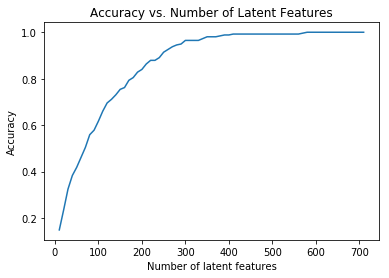

In [35]:
# Number of latent features for SVD with training set
test_num_latent_feats(u_train_sub, s_train, vt_train, ua_train_sub, 10, 10)

#### From the accuracy plot above, the optimal number of latent features is about 300. With 300 latent features, articles were recommended to the subset of 20 users that were in both the training and test sets with an accuracy of greater than 95%.

### <a class="anchor" id="conclusion">Part VI: Conclusion</a>

To test if the new recommendation system is an improvement to the current system, I would set up an AB test. The experiment would use account-based diversion since users are required to register for an account in order to use this platform. Users would be randomly assigned to the control group and experimental group. The novelty bias is of no concern in this case because the recommendation method is not something tangible that the users will notice. After deciding the appropriate experiment size, I will run the experiment until there is an adequate number of users in both groups. The new system will be deployed if the results are both statistically and practically significant.

The details of the experiment are as follows:
- Unit of diversion: account-based
- Control group: recommendations are made using the current system
- Experimental group: recommendations are made using the new system
- Invariant metric: number of unique users in each group should not be significantly different
- Evaluation metric: average user engagement time
- Null hypothesis: user engagement with the new system is less than or equal to user engagement with the current system
- Alternate hypothesis: user engagement with the new system is greater than user engagement with the current system

In [36]:
# Generate HTML
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0